In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [4]:
from tensorflow.keras.models import Sequential    # These are the only parts of keras we need, so we don't need to import tensorflow/full keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
from matplotlib import pyplot
from matplotlib import figure

In [6]:
from math import sqrt
from numpy import concatenate

In [7]:
dataset = pd.read_csv('../data/clean_data/df260_fewerCols.csv', header=0, index_col=0)

value = dataset.to_numpy()
value.shape

(7439, 32)

In [8]:
dataset.head()

,Date,Wind_Direction_Vector,Avg_Temp,Min_Temp,Min_Temp_Hour,Max_Temp,Max_Temp_Hour,Min_Temp_at_10cm,Min_Temp_at_10cm_Hour,Sunshine_Duration_by_radiation,...,Minimum_encountered_visibility_hour,Maximum_encountered_visibility,Maximum_encountered_visibility_hour,Time_average_cloud_cover,Time_average_relative_humidity(percent),Maximum_relative_humidity(percent),Maximum_relative_humidity_hour,Minimum_relative_humidity(percent),Minimum_relative_humidity_hour,Reference_crop_evaporation
STN,,,,,,,,,,,,,,,,,,,,,
260,01/01/2000,237,61,35,19,81,12,-20,24,0,...,9,63,14,7,97,99,9,93,16,1
260,02/01/2000,205,73,54,1,87,18,43,6,0,...,6,50,24,8,97,99,1,93,22,1
260,03/01/2000,212,84,64,24,96,13,65,24,0,...,16,62,3,8,94,97,15,90,11,0
260,04/01/2000,231,64,43,8,94,16,27,24,0,...,10,80,23,7,94,99,10,83,23,0
260,05/01/2000,191,44,14,9,74,14,-21,12,65,...,9,75,1,3,90,95,8,82,14,4


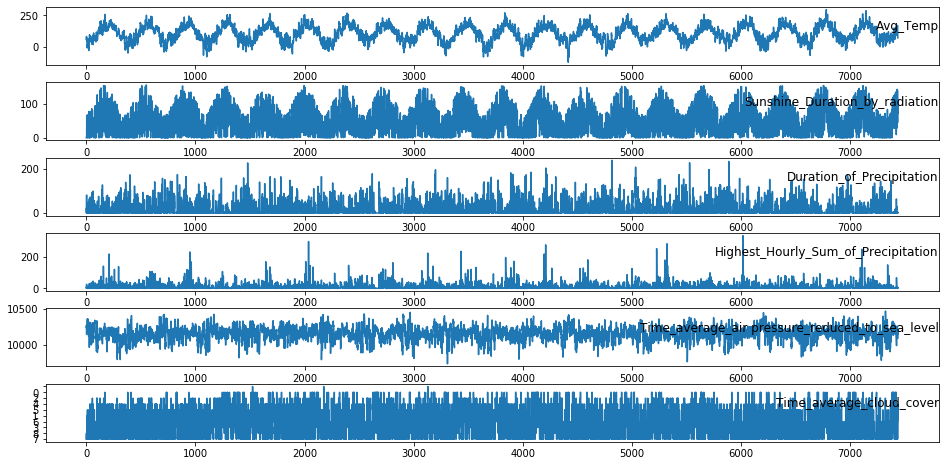

In [8]:
groups = [2,9,12,14,16,25]
i = 1
# plot each column
pyplot.figure(figsize=(16,8))       # Increase the size of the plot
pyplot.subplots_adjust(hspace=0.3)  # Increase the space between plots
for group in groups:

    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(value[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

deleting the date since it doesn't fit the float format and also row 24 because they cant be transfered to float

In [9]:
values = np.delete(value,0,1) 
values = np.delete(values,24,1) # deleting this column since its weird ¯\_(ツ)_/¯  
values_backup = values

values.shape

(7439, 30)

In [11]:
values = values_backup

In [12]:
print(values.shape)

# integer encode direction
encoder = LabelEncoder()
values[:,29] = encoder.fit_transform(values[:,29])


# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[30,32,33,34,35,35,36,37,38,
                                39,40,41,42,43,44,45,46,47,48,
                                49,50,51,52,53,54,55,56,57,58,59]], axis=1, inplace=True)

reframed.head()

(7439, 30)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var28(t-1),var29(t-1),var30(t-1),var2(t)
1,0.657382,0.435407,0.542373,0.782609,0.325688,0.478261,0.458333,1.000000,0.000000,0.000000,...,0.347826,0.746988,0.565217,0.956522,0.982456,0.347826,0.927711,0.652174,0.016949,0.464115
2,0.568245,0.464115,0.588378,0.000000,0.339450,0.739130,0.604167,0.000000,0.000000,0.000000,...,0.217391,0.590361,1.000000,0.956522,0.982456,0.000000,0.927711,0.913043,0.016949,0.490431
3,0.587744,0.490431,0.612591,1.000000,0.360092,0.521739,0.655093,1.000000,0.000000,0.000000,...,0.652174,0.734940,0.086957,0.913043,0.947369,0.608696,0.891566,0.434783,0.000000,0.442584
4,0.640669,0.442584,0.561743,0.304348,0.355505,0.652174,0.567130,1.000000,0.000000,0.000000,...,0.391304,0.951807,0.956522,0.913043,0.982456,0.391304,0.807229,0.956522,0.000000,0.394737
5,0.529248,0.394737,0.491525,0.347826,0.309633,0.565217,0.456019,0.333333,0.419355,0.863158,...,0.347826,0.891566,0.000000,0.855072,0.912281,0.304348,0.795181,0.565217,0.067797,0.461722


In [148]:
# split int# defines the amount of days as training 
# total amount of days minus the training days will be test dataseto train and test sets
values = reframed.values
n_train_days = 6000
train = values[:n_train_days, :]
test = values[n_train_days:, :]


# split into input and outputs
# In train and test the last colum includes the output, this has to be removed and added to the test/train_Y
train_y = train[:,-1]
train_X = np.delete(train,-1,1)

test_y = test[:,-1]
test_X = np.delete(test,-1,1)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6000, 1, 30) (6000,) (1438, 1, 30) (1438,)


Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


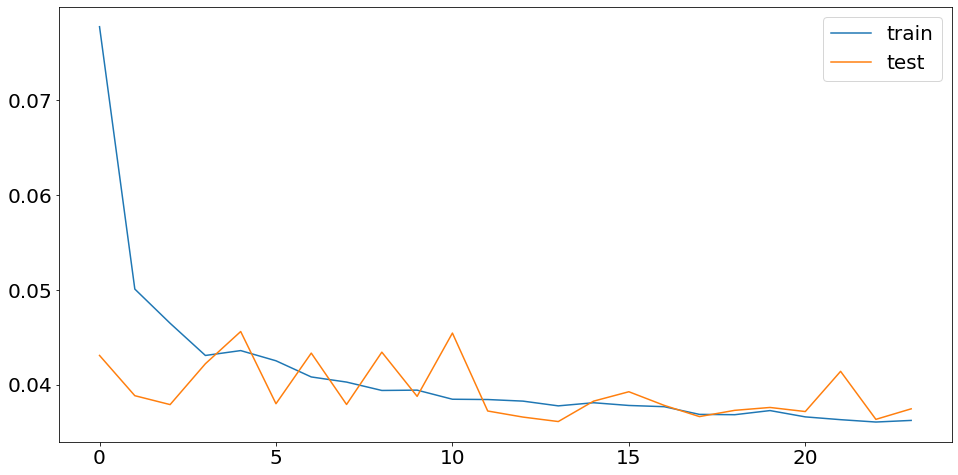

In [166]:
# design network
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)

# fit network
history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                    validation_data=(test_X, test_y), verbose=0, batch_size=32)
# plot history
pyplot.figure(figsize=(16,8))       # Increase the size of the plot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [167]:
# make a prediction
yhat = model.predict(test_X)
test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat, test_X_new[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_new = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_new, test_X_new[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE


print(inv_yhat)


rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[268.31543 278.11337 286.076   ... 234.67397 173.42969 185.62898]
Test RMSE: 16.309


# Trying out the optimal ratio between test and train data
## Takes a lot of time

In [94]:
RMSE =  []
for i in range(1,int(reframed.shape[0]),100):
    values = values_backup
    train_X, test_y, test_X, train_y, encoder = preprocess_for_LSTM(values, i)
    
    
    model = Sequential()
    model.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                            verbose=1, mode='auto', restore_best_weights=True)

    # fit network
    history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                        validation_data=(test_X, test_y), verbose=0, batch_size=32)
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    RMSE.append(rmse)


Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Test RMSE: 54.852
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Test RMSE: 48.897
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test RMSE: 19.492
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test RMSE: 17.337
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test RMSE: 16.595
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test RMSE: 16.315
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test RMSE: 16.324
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test RMSE: 16.587
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test RMSE: 16.122
Restoring model weights from the end of the best epoch.
Epoch 00022: early stoppin

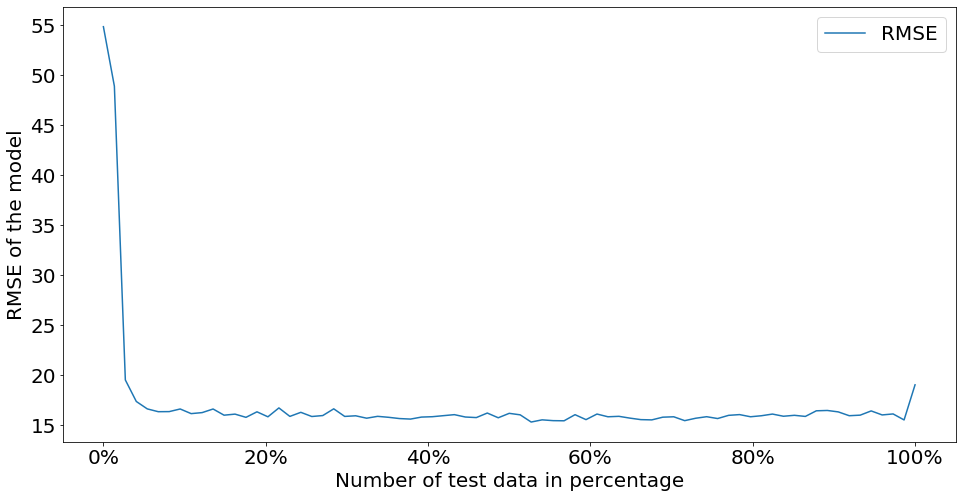

In [115]:
import matplotlib.ticker as mtick
perc = np.linspace(0,100,len(RMSE))
pyplot.rcParams.update({'font.size': 20})

fig = pyplot.figure(1, figsize=(16,8))

ax = fig.add_subplot(1,1,1)

ax.plot(perc, RMSE, label = "RMSE")
pyplot.xlabel("Number of test data in percentage",size= 20)
pyplot.ylabel("RMSE of the model", size=20)
pyplot.legend(prop={'size': 20})


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)


pyplot.show()

In [124]:
length_of_RMSE = len(RMSE)
pos = RMSE.index(min(RMSE))

print("Min of RMSE is " , min(RMSE), ", this hapend with the the training dataset being ", 
      pos/length_of_RMSE, " percent of the total data." )


min of RMSE is  15.280254432996506 , this hapend with the the training dataset being  0.52  percent of the total data.


# Trying out the best LSTM internal node size
## Takes a lot of time

In [125]:
RMSE1 = [0] * 30 # Testing 30 different LSTM sizes 
repetitions = 10

for j in range (repetitions):
    counter = 0
    for i in range(1, 150, 5):
        
        values = values_backup
        train_X, test_y, test_X, train_y, encoder = preprocess_for_LSTM(values)

        model = Sequential()
        model.add(LSTM(i, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                                verbose=1, mode='auto', restore_best_weights=True)

        # fit network
        history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                            validation_data=(test_X, test_y), verbose=0, batch_size=32)
        # make a prediction
        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        
        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        
        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))     
        RMSE1[counter] = RMSE1[counter] + rmse 
        print("j: ", j, "  i: ", i, "  counter: ", counter, "  new value: ", RMSE1[counter])
        counter += 1


Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
j:  0   i:  1   counter:  0   new value:  16.96436029632924
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  0   i:  6   counter:  1   new value:  16.512554594262987
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  0   i:  11   counter:  2   new value:  16.43405474974384
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  0   i:  16   counter:  3   new value:  16.336836043556982
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
j:  0   i:  21   counter:  4   new value:  16.266143761240034
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
j:  0   i:  26   counter:  5   new value:  16.117472466276215
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
j:  0   i:  31   counter:  6   new value:  1

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
j:  1   i:  131   counter:  26   new value:  32.73587305201501
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  1   i:  136   counter:  27   new value:  32.12759791798861
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  1   i:  141   counter:  28   new value:  31.980914114996853
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  1   i:  146   counter:  29   new value:  32.16841526688717
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
j:  2   i:  1   counter:  0   new value:  50.6924517016718
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  2   i:  6   counter:  1   new value:  48.702549724735114
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
j:  2   i:  11   counter:  2   new valu

j:  3   i:  111   counter:  22   new value:  65.01657947194343
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  3   i:  116   counter:  23   new value:  64.75610645506919
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  3   i:  121   counter:  24   new value:  64.23465872345217
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  3   i:  126   counter:  25   new value:  63.75790892594067
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
j:  3   i:  131   counter:  26   new value:  65.09666688794442
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  3   i:  136   counter:  27   new value:  64.2463635182981
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  3   i:  141   counter:  28   new value:  63.6779533213762
Restoring model weights from the end of the best epoch.
E

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
j:  5   i:  96   counter:  19   new value:  96.74312923621392
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  5   i:  101   counter:  20   new value:  97.30286957899698
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  5   i:  106   counter:  21   new value:  95.9985960825528
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  5   i:  111   counter:  22   new value:  96.78696734771209
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  5   i:  116   counter:  23   new value:  97.01258175266204
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
j:  5   i:  121   counter:  24   new value:  96.3605423571672
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
j:  5   i:  126   counter:  25   new 

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  7   i:  76   counter:  15   new value:  127.99019949732208
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  7   i:  81   counter:  16   new value:  128.2589372308629
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  7   i:  86   counter:  17   new value:  128.66092015597349
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  7   i:  91   counter:  18   new value:  128.28058718169163
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  7   i:  96   counter:  19   new value:  128.62254980308114
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  7   i:  101   counter:  20   new value:  129.1619155388546
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
j:  7   i:  106   counter:  21   ne

Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  9   i:  56   counter:  11   new value:  159.95663914040608
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  9   i:  61   counter:  12   new value:  160.62168333069678
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  9   i:  66   counter:  13   new value:  161.08979510256657
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
j:  9   i:  71   counter:  14   new value:  160.620616081219
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  9   i:  76   counter:  15   new value:  160.7748637367742
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
j:  9   i:  81   counter:  16   new value:  159.83754681165095
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
j:  9   i:  86   counter:  17   new v

In [127]:
final = [0] * 30
for i in range(30):
    final[i] = RMSE1[i]/repetitions

In [128]:
print(final)

[16.835512448300435, 16.43105841078474, 16.18833155781303, 16.050724380852667, 16.06307489663981, 16.08131431752326, 15.877149807177517, 15.986097763007612, 16.108547405508496, 16.027459149028736, 16.139726991511516, 15.995663914040609, 16.06216833306968, 16.108979510256656, 16.0620616081219, 16.07748637367742, 15.983754681165095, 16.092980033048228, 16.00901881723653, 16.013052632919955, 16.153709734074276, 16.06574195577174, 16.13810832952742, 16.191075573160166, 15.998284395778404, 15.94558346333648, 16.187517164367865, 16.06836153743309, 16.024673956565273, 16.072420674961837]


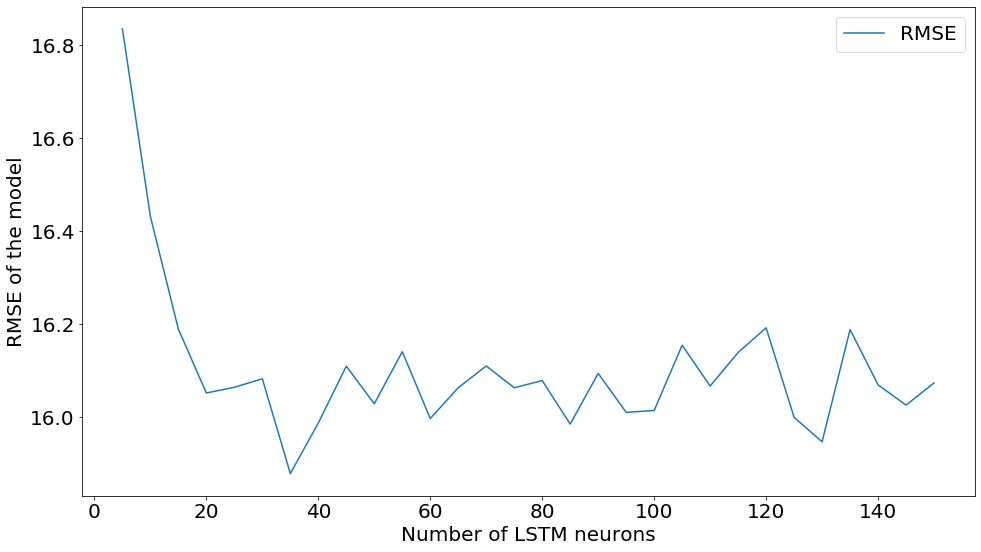

In [133]:
import matplotlib.ticker as mtick
x_values = np.linspace(5,150,len(final))

fig = pyplot.figure(1, figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(x_values, final, label = "RMSE")
pyplot.xlabel("Number of LSTM neurons")
pyplot.ylabel("RMSE of the model")
pyplot.legend()

pyplot.show()

# TEST

In [ ]:
rmse1 = 0 
for i in range(10):
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                            verbose=1, mode='auto', restore_best_weights=True)

    # fit network
    history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                        validation_data=(test_X, test_y), verbose=0, batch_size=32)
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    

# Functions

In [63]:
def preprocess_for_LSTM(values, n_train_days = 6000):
    encoder = LabelEncoder()
    values[:,29] = encoder.fit_transform(values[:,29])

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[30,32,33,34,35,35,36,37,38,
                                    39,40,41,42,43,44,45,46,47,48,
                                    49,50,51,52,53,54,55,56,57,58,59]], axis=1, inplace=True)
    values = reframed.values
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]


    # split into input and outputs
    # In train and test the last colum includes the output, this has to be removed and added to the test/train_Y
    train_y = train[:,-1]
    train_X = np.delete(train,-1,1)

    test_y = test[:,-1]
    test_X = np.delete(test,-1,1)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return train_X, test_y, test_X, train_y, encoder

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg


In [182]:
import dill
import os
import pickle
if not os.path.isdir('models'):
    os.mkdir('models')

with open('models/basic_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)